# 파충강(거북목, 뱀목, 악어목) COI 염기서열 추출 후 군집화(Alignment 과정 x + 비지도학습)

## 데이터 수집 자동 크롤러를 위한 함수들(getOrganism() -> getGenbank())

In [42]:
#[220505_1137]UPDATED 지금까지 구성을 전부 정리함
from Bio import Entrez, SeqIO, AlignIO
from Bio.Align.Applications import MuscleCommandline
from pathlib import Path
from Bio import GenBank
from Bio.SeqUtils import GC

Entrez.email = "nagabuti13@naver.com"

#[220502_1717]CREATED getIdList: NCBI에서 keyword를 검색하여 script의 id를 추출한다
#[220512_1210]NOTED esearch()의 파라미터에 id의 개수를 조절하는 retmax 파라미터가 존재
def getIdlist(database, keyword):
    handle = Entrez.esearch(db = database, retmax = 10000, term = keyword)
    records = Entrez.read(handle)
    return records["IdList"]

#[220505_1717]CREATED getFastaFile: NCBI에서 id를 검색하여 얻은 fasta파일을 컴퓨터에 저장한다
def getFasta(id):
    handle = Entrez.efetch(db = 'nucleotide', id = id, rettype = 'fasta', retmode = 'text')
    record = SeqIO.read(handle, 'fasta')
    print('## creating ' + record.id + '.fasta...')
    with open(record.id + '.fasta', 'w') as f:
        f.write('>' + record.description + '\n')
        f.write(str(record.seq) + '\n')
    
#[220502_1717]CREATED getAlnFile: 다중염기서열을 생성하는 툴 중 하나인 MUSCLE로 aln파일을 생성한다
def getAln(filename):
    muscle_exe = '/Users/kimjoonsu/muscle3.8.31_i86darwin64'
    cmd_line = MuscleCommandline(muscle_exe, input = filename,
                             out = Path(filename).stem + '.aln', clw = ' ')
    print(cmd_line)
    stdout, stderr = cmd_line()   
    
#[220509_1517]CREATED ncbi에서 alignment의 각 record genbank파일로부터 종 이름을 반환
def getGenbank(id):
    handle = Entrez.efetch(db = "nucleotide", rettype = "gb", id = id, retmode = "text")
    r = GenBank.read(handle)
    #[220811_1431]NOTED getOrganism() -> getGenbank()
    return r

In [2]:
#[220505_2320]CREATED 차레대로 토끼, 쥐, 다람쥐의 COI 염기서열 종 목록
#[220520_0628]CREATED 종 9개로 제한
#[220811_1321]CREATED 9개의 종을 쿼리로 날리고 부정확한 검색 결과를 제거하기 위해 CO1 여부와 종 명칭 일치 여부를 확인하여 정확한 FASTA파일만을 수집하도록 함 -> 기존 144개보다 3배 많은 418개 데이터 확보
#[220818_1643]CREATED 파충강의 거북, 뱀, 악어목에 속하는 9종 선정
species = ['Trachemys scripta elegans', 'Pelodiscus sinensis', 'Caretta caretta', 
           'Ophiophagus hannah', 'Gekko gecko', 'Varanus indicus', 
           'Alligator sinensis', 'Gavialis gangeticus', 'Crocodylus porosus']
count = 0

for s in species:
    Idlist = getIdlist('nucleotide', 'coi ' + s)
    Idlist = [id for id in Idlist if getGenbank(id).organism in s and 'COI' in getGenbank(id).definition]
    for id in Idlist:
        getFasta(id)
        count += 1
print(count)

## creating MH274719.1.fasta...
## creating MW774636.1.fasta...
## creating MW774635.1.fasta...
## creating MW774634.1.fasta...
## creating MW774633.1.fasta...
## creating MW774632.1.fasta...
## creating MW774631.1.fasta...
## creating MW774630.1.fasta...
## creating MW774629.1.fasta...
## creating MW774628.1.fasta...
## creating MW774627.1.fasta...
## creating MW774626.1.fasta...
## creating MW774625.1.fasta...
## creating MW774624.1.fasta...
## creating MW774623.1.fasta...
## creating MW774622.1.fasta...
## creating KX559045.1.fasta...
## creating KX559044.1.fasta...
## creating MZ046118.1.fasta...
## creating MZ046117.1.fasta...
## creating MZ046116.1.fasta...
## creating MZ046115.1.fasta...
## creating MZ046114.1.fasta...
## creating MZ046113.1.fasta...
## creating MZ046112.1.fasta...
## creating MZ046111.1.fasta...
## creating MZ046110.1.fasta...
## creating MZ046109.1.fasta...
## creating MZ046108.1.fasta...
## creating MZ046107.1.fasta...
## creating MZ046106.1.fasta...
## creat

In [10]:
def calSilhouette(df):
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score
    import numpy as np

    df['sil_sam'] = silhouette_samples(df.loc[:,'AAA':'GC-contents'], df['target'])
    #[220805_1651]NOTED silhouette_samples: 점의 실루엣 계수
    sil_tot = silhouette_score(df.loc[:,'AAA':'GC-contents'], df['target'])
    #[220805_1652]NOTED silhouette_score: 전체의 실루엣 계수
    sil_clu = df.groupby('target')['sil_sam'].mean()
    score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
    #print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
    #print('score: {0:.3f}'.format(score_k))
    #[220805_1712]NOTED 전체 실루엣 계수와 군집 별 실루엣 계수 간의 편차의 제곱을 구하여 성능 지표로 활용
    #print('---------------')
    return sil_tot / score_k

## alignment 대신 GC함량 값으로 시퀀스 슬라이싱

### GC함량 최댓값 범위 확인

In [43]:
import pandas as pd
import numpy as np

file = SeqIO.parse('all_reptilia_coi.fasta', 'fasta')

l = []
for record in file:
    l.append(len(record.seq))
k_gc = min(l)
#k_gc += 350
print(k_gc)
#[220805_1705]NOTED 길이가 가장 짧은 시퀀스의 bp를 k-mers의 k로 설정

gc_df = pd.DataFrame()
gc_df['start index'] = 0
gc_df['gc-contents'] = 0

file = SeqIO.parse('all_reptilia_coi.fasta', 'fasta')

for i, record in enumerate(file):
    index = 0
    gc_rates = []
    while(index + k_gc <= len(record.seq)):
        mer = record.seq[index:index + k_gc]
        gc_rates.append(GC(mer))
        index += 1
    if index == 0:
        gc_rates.append(GC(record.seq))
    gc_df.loc[i, 'start index'] = gc_rates.index(max(gc_rates))
    #[220805_1706]NOTED GC함량이 가장 높은 mer의 시작 인덱스를 저장
    gc_df.loc[i, 'gc-contents'] = max(gc_rates)
    #[220805_1706]NOTED GC함량이 가장 높은 mer의 GC함량을 저장

210


### 기존 데이터 슬라이싱 후 3-mer 적용

In [23]:
import pandas as pd
import numpy as np

file = SeqIO.parse('all_reptilia_coi.fasta', 'fasta')

k = 3
dict = {}
df = pd.DataFrame()

#[220513_1700]CREATED AGCT 외의 염기를 처리하기 위해 사전형에 key, value로 저장 
base_dict = {'A':'A', 'G':'G', 'C':'C', 'T':'T', 'U':'U',
'Y':'T', 'R':'A', 'S':'C', 'W':'A', 'K':'G', 'M':'C', 'B':'C', 'D':'G', 'H':'T', 'V':'C', 'N':'A'}

#[220508_1735]CREATED k = 3인 kmer의 모든 경우의 수를 사전형에 미리 저장
def init(datatype):
    for i in range(4):
        for j in range(4):
            for k in range(4):
                datatype[list(base_dict.keys())[i] + list(base_dict.keys())[j] + list(base_dict.keys())[k]] = 0
    #[220509_1517]CREATED k-means는 unsupervised이지만, 여기서는 표본의 타겟을 ncbi에서부터 추출가능하므로 타겟 피처 생성
    datatype['GC-contents'] = 0
    datatype['target'] = 0
    
init(df)

for i, record in enumerate(file):
    init(dict)
    record.seq = record.seq[int(gc_df.loc[i, 'start index']): int(gc_df.loc[i, 'start index']) + k_gc]
    #[220805_1023]CREATED 최대 GC 값 범위로 기존 데이터 슬라이싱
    dict['GC-contents'] = gc_df.loc[i, 'gc-contents']
    #[220805_1025]CREATED 최대 GC 값 저장
    dict['target'] = getGenbank(record.id).organism
    
    index = 0
    
    if(len(record.seq) >= k):
        while(index + k <= len(record.seq)):
            mer = record.seq[index:index + k]
            for p in range(k):
                mer = mer.replace(mer[p], base_dict.get(mer[p]))
            dict[mer] += 1
            index += 1
    df.loc[i] = dict

In [24]:
#[220811_1437]NOTED 9종으로 잘 크롤링되었음을 확인
df['target'].unique()

array(['Ophiophagus hannah', 'Gekko gecko', 'Varanus indicus',
       'Crocodylus porosus', 'Caretta caretta', 'Gavialis gangeticus',
       'Pelodiscus sinensis', 'Trachemys scripta elegans',
       'Alligator sinensis'], dtype=object)

In [25]:
""" # row 생략 없이 출력
pd.set_option('display.max_rows', None)
# col 생략 없이 출력
pd.set_option('display.max_columns', None)

 """
df

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target
0,1,2,3,2,3,4,7,3,6,0,...,5,1,4,6,3,0,5,6,50.000000,Ophiophagus hannah
1,1,2,3,2,3,4,7,3,6,0,...,5,1,4,6,3,0,5,6,50.000000,Ophiophagus hannah
2,1,2,3,2,3,4,7,3,6,0,...,5,1,4,6,3,0,5,6,50.000000,Ophiophagus hannah
3,2,1,5,2,1,4,3,3,3,4,...,2,4,4,3,5,2,3,5,56.190476,Gekko gecko
4,7,1,5,5,1,4,4,1,5,0,...,7,1,7,1,2,2,4,0,50.952381,Varanus indicus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,0,2,3,1,1,1,8,1,5,2,...,1,0,5,7,3,0,6,5,54.285714,Gekko gecko
369,1,1,1,3,0,3,5,2,5,1,...,1,1,7,8,1,0,5,3,54.761905,Gekko gecko
370,1,1,2,1,1,3,7,2,4,1,...,1,0,5,9,1,0,5,3,54.761905,Gekko gecko
371,1,1,1,2,0,3,5,2,5,1,...,1,1,7,8,1,0,5,3,54.761905,Gekko gecko


In [26]:
#[220509_1621]CREATED 레이블 인코딩으로 종 이름 -> 고유 숫자
from sklearn.preprocessing import LabelEncoder

a = df['target']
encoder = LabelEncoder()
labels = encoder.fit_transform(a)
#[220509_1622]NOTED* 종의 총 개수 = 19인 것을 알 수 있으므로 KMeans의 파라미터인 n_clusters를 14 -> 19로 수정
#[220513_1830]NOTED 종: 101개
#[220519_1745]NOTED 종: 9개
print(labels)

df['target'] = labels
df.head()

[5 5 5 4 8 8 8 2 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 6 6 6 6 6 6 5 1 1 5
 1 1 1 1 1 1 1 7 7 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 3 3 7 8 8 8
 8 4 1 3 3 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4
 4 4 4]


,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target
0,1,2,3,2,3,4,7,3,6,0,...,5,1,4,6,3,0,5,6,50.000000,5
1,1,2,3,2,3,4,7,3,6,0,...,5,1,4,6,3,0,5,6,50.000000,5
2,1,2,3,2,3,4,7,3,6,0,...,5,1,4,6,3,0,5,6,50.000000,5
3,2,1,5,2,1,4,3,3,3,4,...,2,4,4,3,5,2,3,5,56.190476,4
4,7,1,5,5,1,4,4,1,5,0,...,7,1,7,1,2,2,4,0,50.952381,8


In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
#[220805_1714]NOTED* GC함량을 정규화
scaler.fit(df['GC-contents'].array.reshape(-1, 1))
gc_scaled = scaler.transform(df['GC-contents'].array.reshape(-1, 1))
df['GC-contents'] = gc_scaled

In [28]:
df

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target
0,1,2,3,2,3,4,7,3,6,0,...,5,1,4,6,3,0,5,6,0.545455,5
1,1,2,3,2,3,4,7,3,6,0,...,5,1,4,6,3,0,5,6,0.545455,5
2,1,2,3,2,3,4,7,3,6,0,...,5,1,4,6,3,0,5,6,0.545455,5
3,2,1,5,2,1,4,3,3,3,4,...,2,4,4,3,5,2,3,5,0.939394,4
4,7,1,5,5,1,4,4,1,5,0,...,7,1,7,1,2,2,4,0,0.606061,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,0,2,3,1,1,1,8,1,5,2,...,1,0,5,7,3,0,6,5,0.818182,4
369,1,1,1,3,0,3,5,2,5,1,...,1,1,7,8,1,0,5,3,0.848485,4
370,1,1,2,1,1,3,7,2,4,1,...,1,0,5,9,1,0,5,3,0.848485,4
371,1,1,1,2,0,3,5,2,5,1,...,1,1,7,8,1,0,5,3,0.848485,4


In [29]:
calSilhouette(df)

3.387302719971239

In [30]:
def cal_accuracy(target, cluster):
    ct = pd.crosstab(target, cluster)
    accuracy = 0
    for i in range(ct.iloc[:, 0].count()):
        accuracy += ct.iloc[i,:].max() / ct.iloc[i,:].sum()
    return accuracy / ct.iloc[:, 0].count()
#[220812_1340]CREATED 비지도학습에서의 정확도 계산 함수 생성

### 그냥 했을 때

In [31]:
calSilhouette(df)

3.387302719971239

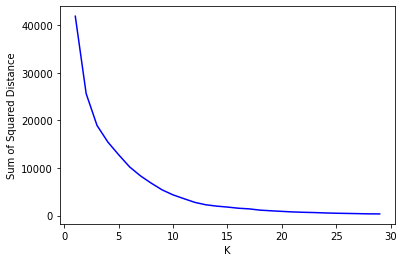

In [32]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

ks = range(1, 30)
sse = []
for k in ks:
    km = KMeans(n_clusters = k, max_iter = 1000)
    km.fit(df.loc[:, :'GC-contents'])
    sse.append(km.inertia_)

plt.plot(ks, sse, 'b')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distance')
plt.show()
#[220805_1649]CREATED k = 6일 때가 최적 but 실제는 9

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

ks = range(2, 20)
for k in ks:
    kmeans = KMeans(n_clusters = k, max_iter=500)
    kmeans.fit(df.loc[:, :'GC-contents'])
    df['cluster'] = kmeans.labels_
    df['sil_sam'] = silhouette_samples(df.loc[:, :'GC-contents'], df['cluster'])
    sil_tot = silhouette_score(df.loc[:, :'GC-contents'], df['cluster'])
    sil_clu = df.groupby('cluster')['sil_sam'].mean()
    score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
    print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
    print('score: {0:.3f}'.format(score_k))
    print('---------------')
    df.drop('cluster', axis = 1, inplace = True)
    df.drop('sil_sam', axis = 1, inplace = True)
#[220801_1637]CREATED 전체 실루엣 계수 평균이 높으면서 군집 별 실루엣 계수와 크게 차이나지 않는 k 값은 9이다.

전체 실루엣 계수 평균: 0.478
군집 별 실루엣 계수 평균: 
cluster
0    0.667854
1    0.181757
Name: sil_sam, dtype: float64
score: 0.243
---------------
전체 실루엣 계수 평균: 0.540
군집 별 실루엣 계수 평균: 
cluster
0    0.475352
1    0.637818
2    0.305079
Name: sil_sam, dtype: float64
score: 0.133
---------------
전체 실루엣 계수 평균: 0.544
군집 별 실루엣 계수 평균: 
cluster
0    0.748121
1    0.379732
2    0.364703
3    0.407981
Name: sil_sam, dtype: float64
score: 0.171
---------------
전체 실루엣 계수 평균: 0.585
군집 별 실루엣 계수 평균: 
cluster
0    0.748121
1    0.554459
2    0.359396
3    0.407981
4    0.464428
Name: sil_sam, dtype: float64
score: 0.143
---------------
전체 실루엣 계수 평균: 0.616
군집 별 실루엣 계수 평균: 
cluster
0    0.407981
1    0.554459
2    0.541241
3    0.748121
4    0.357737
5    0.879922
Name: sil_sam, dtype: float64
score: 0.166
---------------
전체 실루엣 계수 평균: 0.638
군집 별 실루엣 계수 평균: 
cluster
0    0.735089
1    0.774010
2    0.234164
3    0.557481
4    0.758083
5    0.873468
6    1.000000
Name: sil_sam, dtype: float64
score: 0.205
--------------

In [34]:
def cal_accuracy(target, cluster):
    ct = pd.crosstab(target, cluster)
    accuracy = 0
    for i in range(ct.iloc[:, 0].count()):
        accuracy += ct.iloc[i,:].max() / ct.iloc[i,:].sum()
    return accuracy / ct.iloc[:, 0].count()
#[220812_1340]CREATED target수 <= cluster수일 때의 비지도학습에서의 정확도 계산 함수 생성

In [41]:
km = KMeans(n_clusters = 11, max_iter = 1000)
km.fit(df.loc[:, :'GC-contents'])
df['cluster'] = km.labels_
cal_accuracy(df['target'], df['cluster'])

0.917076642222841

In [36]:
ct = pd.crosstab(df['target'], df['cluster'])
ct

cluster,0,1,2,3,4,5,6,7,8,9,10
target,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,7,0,0
1,0,0,0,0,12,0,0,0,0,0,0
2,0,0,21,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,26,0,0,0,0
4,0,165,0,46,0,0,0,0,0,0,17
5,0,0,0,0,0,0,0,0,0,11,0
6,42,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,18,0,0,0,0,0
8,0,0,0,0,1,0,0,4,0,2,0


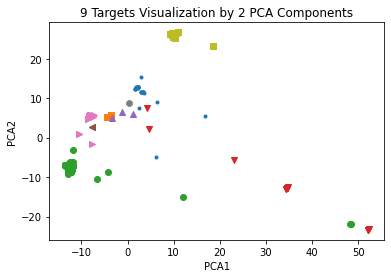

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['target'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('9 Targets Visualization by 2 PCA Components')
plt.show()

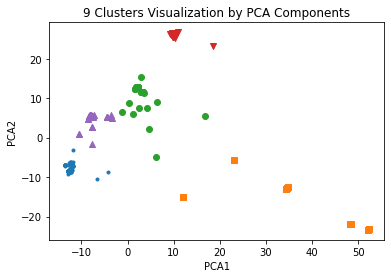

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['cluster'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('9 Clusters Visualization by PCA Components')
plt.show()

In [ ]:
km2 = KMeans(n_clusters = 6, max_iter = 1000)
km2.fit(df[['tsne_x', 'tsne_y']])
cal_accuracy(df['target'], km2.labels_)

0.9419984255510572

### PCA 차원축소 사용했을 때

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2).fit_transform(df.loc[:,:'GC-contents'])

df['pca_x'] = pca[:, 0]
df['pca_y'] = pca[:, 1]
df.head()

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TTG,TTC,TTT,GC-contents,target,sil_sam,lda_x,lda_y,pca_x,pca_y
0,1,2,3,2,3,4,7,3,6,0,...,0,5,6,0.545455,5,0.682759,619.004169,109.827173,5.707575,0.816405
1,1,2,3,2,3,4,7,3,6,0,...,0,5,6,0.545455,5,0.682759,619.004169,109.827173,5.707575,0.816405
2,1,2,3,2,3,4,7,3,6,0,...,0,5,6,0.545455,5,0.682759,619.004169,109.827173,5.707575,0.816405
3,2,1,5,2,1,4,3,3,3,4,...,2,3,5,0.939394,4,-0.001229,-245.361482,52.401425,1.473340,-0.440239
4,7,1,5,5,1,4,4,1,5,0,...,2,4,0,0.606061,8,-0.144372,338.355786,-114.230009,5.324334,2.032612


In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

df['sil_sam'] = silhouette_samples(df[['pca_x', 'pca_y']], df['target'])
#[220805_1651]NOTED silhouette_samples: 점의 실루엣 계수
sil_tot = silhouette_score(df[['pca_x', 'pca_y']], df['target'])
#[220805_1652]NOTED silhouette_score: 전체의 실루엣 계수
sil_clu = df.groupby('target')['sil_sam'].mean()
score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
#print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
#print('score: {0:.3f}'.format(score_k))
#[220805_1712]NOTED 전체 실루엣 계수와 군집 별 실루엣 계수 간의 편차의 제곱을 구하여 성능 지표로 활용
#print('---------------')
print(sil_tot / score_k)

3.333103168718249


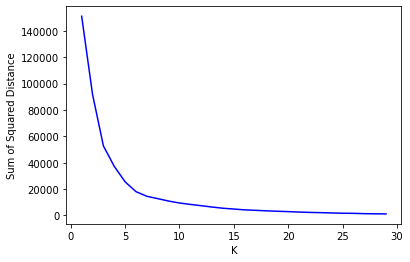

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

ks = range(1, 30)
sse = []
for k in ks:
    km = KMeans(n_clusters = k, max_iter = 1000)
    km.fit(df.loc[:,:'GC-contents'])
    sse.append(km.inertia_)

plt.plot(ks, sse, 'b')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distance')
plt.show()
#[220805_1649]CREATED k = 6일 때가 최적 but 실제는 9

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

ks = range(2, 20)
for k in ks:
    kmeans = KMeans(n_clusters = k, max_iter=500)
    kmeans.fit(df.loc[:,:'GC-contents'])
    df['cluster'] = kmeans.labels_
    df['sil_sam'] = silhouette_samples(df.loc[:,:'GC-contents'], df['cluster'])
    sil_tot = silhouette_score(df.loc[:,:'GC-contents'], df['cluster'])
    sil_clu = df.groupby('cluster')['sil_sam'].mean()
    score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
    print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
    print('score: {0:.3f}'.format(score_k))
    print('---------------')
    df.drop('cluster', axis = 1, inplace = True)
    df.drop('sil_sam', axis = 1, inplace = True)
#[220801_1637]CREATED 전체 실루엣 계수 평균이 높으면서 군집 별 실루엣 계수와 크게 차이나지 않는 k 값은 9이다.

전체 실루엣 계수 평균: 0.550
군집 별 실루엣 계수 평균: 
cluster
0    0.522621
1    0.732302
Name: sil_sam, dtype: float64
score: 0.105
---------------
전체 실루엣 계수 평균: 0.557
군집 별 실루엣 계수 평균: 
cluster
0    0.566766
1    0.680375
2    0.462194
Name: sil_sam, dtype: float64
score: 0.076
---------------
전체 실루엣 계수 평균: 0.596
군집 별 실루엣 계수 평균: 
cluster
0    0.372281
1    0.719427
2    0.680146
3    0.451324
Name: sil_sam, dtype: float64
score: 0.144
---------------
전체 실루엣 계수 평균: 0.675
군집 별 실루엣 계수 평균: 
cluster
0    0.392404
1    0.719368
2    0.671057
3    0.892047
4    0.609274
Name: sil_sam, dtype: float64
score: 0.123
---------------
전체 실루엣 계수 평균: 0.697
군집 별 실루엣 계수 평균: 
cluster
0    0.392404
1    0.609274
2    0.719368
3    0.849561
4    0.892047
5    0.779508
Name: sil_sam, dtype: float64
score: 0.141
---------------
전체 실루엣 계수 평균: 0.719
군집 별 실루엣 계수 평균: 
cluster
0    0.625503
1    0.849795
2    0.708842
3    0.891776
4    0.641492
5    0.779508
6    0.389512
Name: sil_sam, dtype: float64
score: 0.125
--------------

In [ ]:
def cal_accuracy(target, cluster):
    ct = pd.crosstab(target, cluster)
    accuracy = 0
    for i in range(ct.iloc[:, 0].count()):
        accuracy += ct.iloc[i,:].max() / ct.iloc[i,:].sum()
    return accuracy / ct.iloc[:, 0].count()
#[220812_1340]CREATED target수 <= cluster수일 때의 비지도학습에서의 정확도 계산 함수 생성

In [ ]:
km = KMeans(n_clusters = 7, max_iter = 1000)
km.fit(df.loc[:,:'GC-contents'])
df['cluster'] = km.labels_
cal_accuracy(df['target'], df['cluster'])

0.9580802968960865

In [ ]:
ct = pd.crosstab(df['target'], df['cluster'])
ct

cluster,0,1,2,3,4,5,6
target,,,,,,,
0,25,0,0,0,0,1,0
1,0,0,0,0,0,0,7
2,0,111,1,0,2,0,0
3,1,0,26,0,4,0,1
4,0,0,0,0,0,0,3
5,0,0,0,0,0,0,2
6,0,0,0,0,0,21,3
7,0,0,0,0,0,0,1
8,0,0,0,32,0,0,0


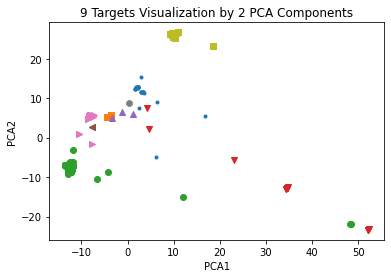

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['target'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('9 Targets Visualization by 2 PCA Components')
plt.show()

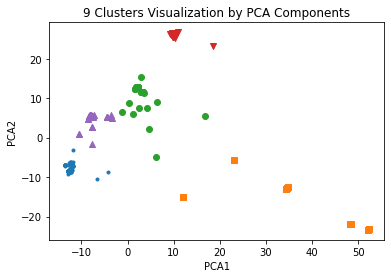

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['cluster'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('9 Clusters Visualization by PCA Components')
plt.show()

In [ ]:
km2 = KMeans(n_clusters = 6, max_iter = 1000)
km2.fit(df[['tsne_x', 'tsne_y']])
cal_accuracy(df['target'], km2.labels_)

0.9419984255510572

### LDA 차원축소 사용했을 때

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components = 2)
lda.fit(df.loc[:, :'GC-contents'], df['target'])
ma_lda = lda.transform(df.loc[:, :'GC-contents'])
print(ma_lda.shape)

df['lda_x'] = ma_lda[:, 0]
df['lda_y'] = ma_lda[:, 1]
df.head()

(373, 2)


,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCT,TTA,TTG,TTC,TTT,GC-contents,target,sil_sam,lda_x,lda_y
0,1,2,3,2,3,4,7,3,6,0,...,6,3,0,5,6,0.545455,5,0.682759,619.004169,109.827173
1,1,2,3,2,3,4,7,3,6,0,...,6,3,0,5,6,0.545455,5,0.682759,619.004169,109.827173
2,1,2,3,2,3,4,7,3,6,0,...,6,3,0,5,6,0.545455,5,0.682759,619.004169,109.827173
3,2,1,5,2,1,4,3,3,3,4,...,3,5,2,3,5,0.939394,4,-0.001229,-245.361482,52.401425
4,7,1,5,5,1,4,4,1,5,0,...,1,2,2,4,0,0.606061,8,-0.144372,338.355786,-114.230009


In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

df['sil_sam'] = silhouette_samples(df[['lda_x', 'lda_y']], df['target'])
#[220805_1651]NOTED silhouette_samples: 점의 실루엣 계수
sil_tot = silhouette_score(df[['lda_x', 'lda_y']], df['target'])
#[220805_1652]NOTED silhouette_score: 전체의 실루엣 계수
sil_clu = df.groupby('target')['sil_sam'].mean()
score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
#print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
#print('score: {0:.3f}'.format(score_k))
#[220805_1712]NOTED 전체 실루엣 계수와 군집 별 실루엣 계수 간의 편차의 제곱을 구하여 성능 지표로 활용
#print('---------------')
print(sil_tot / score_k)

232.68952351308326


In [49]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average = 'macro')
    recall = recall_score(y_test, pred, average = 'macro')
    
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.2f}, 정밀도: {1:.2f}, 재현율: {2:.2f}'.format(accuracy, precision, recall))
    
    
svm_2 = SVC(kernel = 'linear') 
#[220715_1739]NOTED 모델 생성

X = df[['lda_x', 'lda_y']]
y = df['target']

scaler = StandardScaler()
new_X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size = 0.2)
#[220715_1740]NOTED 학습 데이터와 테스트 데이어셋으로 무작위 분리한 뒤 정규화

parameters = {'C':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'gamma':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
#[220715_1741]NOTED 파라미터 후보 설정

grid_svm = GridSearchCV(svm_2, param_grid = parameters, cv = 5)
grid_svm.fit(X_train, y_train)  
#[220711_1658]NOTED 검증 데이터셋 + 학습 데이터셋 = 원래 학습 데이터셋

print(grid_svm.best_params_)
print(grid_svm.best_score_)
best_pred = grid_svm.best_estimator_.predict(X_test)
get_clf_eval(y_test, best_pred)

{'C': 2, 'gamma': 1}
1.0
오차 행렬
[[ 2  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  0  0]
 [ 0  0  0  0 45  0  0  0  0]
 [ 0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0  0  5  0]
 [ 0  0  0  0  0  0  0  0  1]]
정확도: 1.00, 정밀도: 1.00, 재현율: 1.00


### t-sne 차원축소 사용했을 때

In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, perplexity = 30).fit_transform(df.loc[:,:'TTT'])

df['tsne_x'] = tsne[:, 0]
df['tsne_y'] = tsne[:, 1]
df.head()

/Users/biosmu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/biosmu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TTT,GC-contents,target,sil_sam,lda_x,lda_y,pca_x,pca_y,tsne_x,tsne_y
0,1,2,3,2,3,4,7,3,6,0,...,6,0.545455,5,0.982968,619.004169,109.827173,5.707575,0.816405,-7.216290,12.794112
1,1,2,3,2,3,4,7,3,6,0,...,6,0.545455,5,0.982968,619.004169,109.827173,5.707575,0.816405,-7.216256,12.794591
2,1,2,3,2,3,4,7,3,6,0,...,6,0.545455,5,0.982968,619.004169,109.827173,5.707575,0.816405,-7.216088,12.794856
3,2,1,5,2,1,4,3,3,3,4,...,5,0.939394,4,0.998386,-245.361482,52.401425,1.473340,-0.440239,11.584339,0.803448
4,7,1,5,5,1,4,4,1,5,0,...,0,0.606061,8,0.994474,338.355786,-114.230009,5.324334,2.032612,-9.904176,2.373515


In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

df['sil_sam'] = silhouette_samples(df[['tsne_x', 'tsne_y']], df['target'])
#[220805_1651]NOTED silhouette_samples: 점의 실루엣 계수
sil_tot = silhouette_score(df[['tsne_x', 'tsne_y']], df['target'])
#[220805_1652]NOTED silhouette_score: 전체의 실루엣 계수
sil_clu = df.groupby('target')['sil_sam'].mean()
score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
#print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
#print('score: {0:.3f}'.format(score_k))
#[220805_1712]NOTED 전체 실루엣 계수와 군집 별 실루엣 계수 간의 편차의 제곱을 구하여 성능 지표로 활용
#print('---------------')
print(sil_tot / score_k)

0.4686459840248305


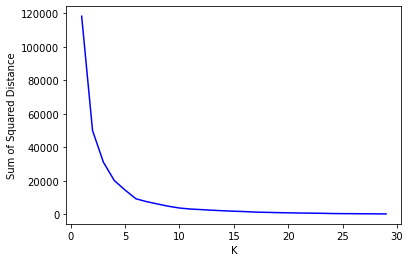

In [51]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

ks = range(1, 30)
sse = []
for k in ks:
    km = KMeans(n_clusters = k, max_iter = 1000)
    km.fit(df[['tsne_x', 'tsne_y']])
    sse.append(km.inertia_)

plt.plot(ks, sse, 'b')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distance')
plt.show()
#[220805_1649]CREATED k = 6일 때가 최적 but 실제는 9

In [52]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

ks = range(2, 20)
for k in ks:
    kmeans = KMeans(n_clusters = k, max_iter=500)
    kmeans.fit(df[['tsne_x', 'tsne_y']])
    df['cluster'] = kmeans.labels_
    df['sil_sam'] = silhouette_samples(df[['tsne_x', 'tsne_y']], df['cluster'])
    sil_tot = silhouette_score(df[['tsne_x', 'tsne_y']], df['cluster'])
    sil_clu = df.groupby('cluster')['sil_sam'].mean()
    score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
    print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
    print('score: {0:.3f}'.format(score_k))
    print('---------------')
    df.drop('cluster', axis = 1, inplace = True)
    df.drop('sil_sam', axis = 1, inplace = True)
#[220801_1637]CREATED 전체 실루엣 계수 평균이 높으면서 군집 별 실루엣 계수와 크게 차이나지 않는 k 값은 9이다.

전체 실루엣 계수 평균: 0.561
군집 별 실루엣 계수 평균: 
cluster
0    0.518211
1    0.608722
Name: sil_sam, dtype: float32
score: 0.045
---------------
전체 실루엣 계수 평균: 0.622
군집 별 실루엣 계수 평균: 
cluster
0    0.591235
1    0.578442
2    0.818328
Name: sil_sam, dtype: float32
score: 0.090
---------------
전체 실루엣 계수 평균: 0.662
군집 별 실루엣 계수 평균: 
cluster
0    0.628252
1    0.577303
2    0.854688
3    0.781985
Name: sil_sam, dtype: float32
score: 0.108
---------------
전체 실루엣 계수 평균: 0.677
군집 별 실루엣 계수 평균: 
cluster
0    0.690776
1    0.567005
2    0.773593
3    0.854688
4    0.217065
Name: sil_sam, dtype: float32
score: 0.172
---------------
전체 실루엣 계수 평균: 0.689
군집 별 실루엣 계수 평균: 
cluster
0    0.593428
1    0.670405
2    0.851212
3    0.771433
4    0.217065
5    0.656254
Name: sil_sam, dtype: float32
score: 0.144
---------------
전체 실루엣 계수 평균: 0.643
군집 별 실루엣 계수 평균: 
cluster
0    0.598382
1    0.517633
2    0.851199
3    0.752369
4    0.561897
5    0.647206
6    0.172303
Name: sil_sam, dtype: float32
score: 0.149
--------------

In [53]:
def cal_accuracy(target, cluster):
    ct = pd.crosstab(target, cluster)
    accuracy = 0
    for i in range(ct.iloc[:, 0].count()):
        accuracy += ct.iloc[i,:].max() / ct.iloc[i,:].sum()
    return accuracy / ct.iloc[:, 0].count()
#[220812_1340]CREATED target수 <= cluster수일 때의 비지도학습에서의 정확도 계산 함수 생성

In [54]:
km = KMeans(n_clusters = 5, max_iter = 1000)
km.fit(df[['tsne_x', 'tsne_y']])
df['cluster'] = km.labels_
cal_accuracy(df['target'], df['cluster'])

0.9551656920077972

In [55]:
ct = pd.crosstab(df['target'], df['cluster'])
ct

cluster,0,1,2,3,4
target,,,,,
0,7,0,0,0,0
1,12,0,0,0,0
2,21,0,0,0,0
3,27,0,0,0,0
4,51,136,0,2,39
5,11,0,0,0,0
6,0,0,42,0,0
7,0,0,18,0,0
8,7,0,0,0,0


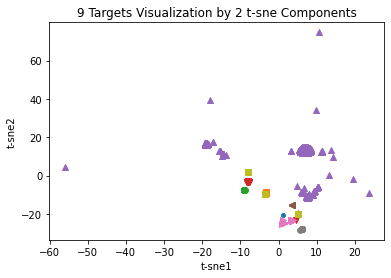

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['target'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'tsne_x'], y = df.loc[j, 'tsne_y'], marker = i)

plt.xlabel('t-sne1')
plt.ylabel('t-sne2')
plt.title('9 Targets Visualization by 2 t-sne Components')
plt.show()

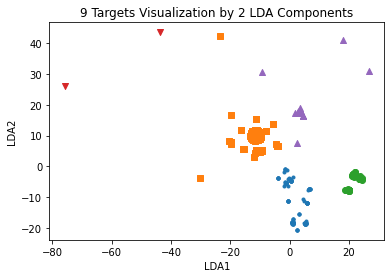

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['cluster'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'tsne_x'], y = df.loc[j, 'tsne_y'], marker = i)

plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.title('9 Targets Visualization by 2 LDA Components')
plt.show()

In [60]:
km2 = KMeans(n_clusters = 4, max_iter = 1000)
km2.fit(df[['tsne_x', 'tsne_y']])
cal_accuracy(df['target'], km2.labels_)

0.956140350877193